# New implementation with SP500 in R

In [88]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
import seaborn as sns
import networkx as nx

os.chdir('/Users/zeyiwang/Documents/YALE/Fall 2023/SDS 665/assn3')

In [89]:
etfs = {"EWJ":"Japan","EWZ":"Brazil","FXI":"China","EWY":"South Korea",
        "EWT":"Taiwan","EWH":"Hong Kong","EWC":"Canada","EWG":"Germany",
        "EWU":"United Kingdom","EWA":"Australia","EWW":"Mexico","EWL":"Switzerland",
        "EWP":"Spain","EWQ":"France","EIDO":"Indonesia","ERUS":"Russia",
        "EWS":"Singapore","EWM":"Malaysia","EZA":"South Africa","THD":"Thailand",
        "ECH":"Chile","EWI":"Italy","TUR":"Turkey","EPOL":"Poland",
        "EPHE":"Philippines","EWD":"Sweden","EWN":"Netherlands","EPU":"Peru",
        "ENZL":"New Zealand","EIS":"Israel","EWO":"Austria","EIRL":"Ireland","EWK":"Belgium"}


In [98]:
# Load prices written by the R script
fname = "weekly_stock.csv"  
df = pd.read_csv(fname)

# Normalize date column name (could be 'date' or 'Date')
date_col = "date" if "date" in df.columns else ("Date" if "Date" in df.columns else None)
if date_col is None:
    raise ValueError("No 'date' or 'Date' column found in CSV.")

df[date_col] = pd.to_datetime(df[date_col])
df = df.set_index(date_col).sort_index()
df.index.name = "Date"

dates = df.index
print(f"{fname}: {df.shape[0]} rows × {df.shape[1]} tickers")
display(df)

weekly_stock.csv: 262 rows × 33 tickers


,ECH,EIDO,EIRL,EIS,ENZL,EPHE,EPOL,EPU,ERUS,EWA,...,EWS,EWT,EWU,EWW,EWY,EWZ,EZA,FXI,THD,TUR
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-20,43.380001,25.950001,40.209999,51.689999,41.439999,34.189999,22.090000,33.840000,32.650002,22.170000,...,22.620001,33.669998,32.470001,51.560001,62.470001,37.119999,60.369999,39.250000,77.470001,36.730000
2017-03-27,43.560001,25.790001,40.060001,51.250000,42.220001,34.160000,21.580000,34.080002,32.119999,22.610001,...,22.809999,33.230000,32.549999,51.169998,61.869999,37.459999,55.189999,38.490002,77.989998,35.799999
2017-04-03,44.849998,26.240000,39.959999,51.470001,42.150002,35.860001,21.959999,34.389999,31.900000,22.309999,...,22.650000,33.240002,32.299999,52.070000,60.349998,37.000000,54.369999,38.740002,78.129997,35.250000
2017-04-10,45.130001,26.010000,40.160000,50.849998,42.310001,36.000000,21.540001,33.750000,30.879999,22.430000,...,22.639999,33.180000,32.419998,51.189999,59.919998,36.090000,57.180000,38.259998,78.650002,36.369999
2017-04-17,44.369999,26.230000,40.810001,50.900002,42.439999,35.810001,22.090000,33.630001,31.070000,22.330000,...,22.559999,32.959999,32.369999,51.369999,60.959999,36.160000,57.720001,37.959999,78.110001,37.779999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-22,25.910000,24.540001,52.169998,73.449997,54.580002,32.490002,18.450001,34.310001,25.000000,24.219999,...,21.330000,64.070000,34.220001,50.070000,72.660004,33.060001,52.189999,35.220001,80.300003,19.040001
2022-02-28,26.959999,24.070000,45.119999,70.720001,55.959999,32.040001,16.150000,36.209999,8.060000,24.770000,...,19.230000,62.470001,31.410000,49.070000,69.989998,34.290001,52.090000,32.970001,79.400002,18.730000
2022-03-07,26.290001,24.360001,45.970001,69.209999,53.880001,30.110001,17.120001,36.820000,8.060000,24.379999,...,19.129999,60.400002,31.500000,49.150002,67.110001,33.369999,52.389999,29.070000,76.129997,18.360001


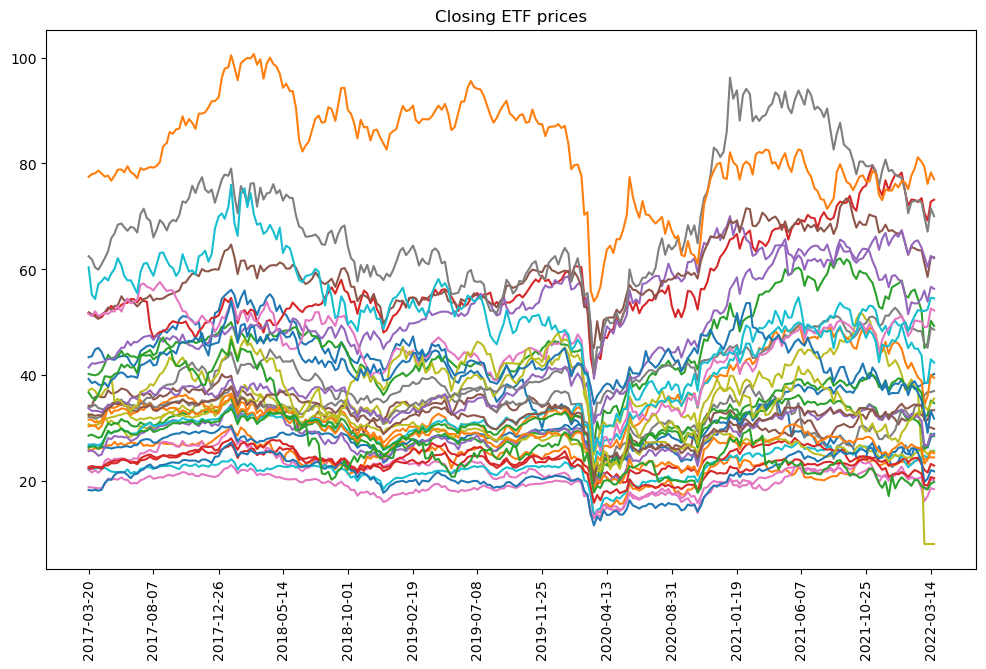

In [91]:
plt.figure(figsize=(12, 7))
plt.plot(df)
plt.xlabel('')
_ = plt.xticks(dates[np.arange(0, len(dates), 20)], rotation=90)
_ = plt.title('Closing ETF prices')
plt.show()

In [92]:
dflogreturn = np.log1p(df.pct_change()).iloc[1:]
dflogreturn

,ECH,EIDO,EIRL,EIS,ENZL,EPHE,EPOL,EPU,ERUS,EWA,...,EWS,EWT,EWU,EWW,EWY,EWZ,EZA,FXI,THD,TUR
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-27,0.004141,-0.006185,-0.003737,-0.008549,0.018648,-0.000878,-0.023358,0.007067,-0.016366,0.019652,...,0.008365,-0.013154,0.002461,-0.007593,-0.009651,0.009118,-0.089711,-0.019553,0.006690,-0.025646
2017-04-03,0.029184,0.017298,-0.002499,0.004284,-0.001659,0.048567,0.017456,0.009055,-0.006873,-0.013357,...,-0.007039,0.000301,-0.007710,0.017436,-0.024874,-0.012356,-0.014969,0.006474,0.001793,-0.015482
2017-04-10,0.006224,-0.008804,0.004993,-0.012119,0.003789,0.003896,-0.019311,-0.018785,-0.032497,0.005364,...,-0.000442,-0.001807,0.003708,-0.017045,-0.007151,-0.024902,0.050392,-0.012468,0.006634,0.031279
2017-04-17,-0.016984,0.008423,0.016056,0.000983,0.003068,-0.005292,0.025213,-0.003562,0.006134,-0.004468,...,-0.003540,-0.006653,-0.001543,0.003510,0.017208,0.001938,0.009400,-0.007872,-0.006890,0.038036
2017-04-24,-0.032760,0.003805,0.032308,0.016561,0.003293,0.000837,0.072878,-0.008061,0.029806,0.005805,...,0.018446,0.023982,0.022301,0.007563,0.018528,0.027548,0.013081,0.014904,-0.007582,0.051333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-22,0.002705,0.022251,-0.041673,0.010126,0.018678,-0.005219,-0.092596,-0.006102,-0.396088,0.009959,...,-0.020878,-0.021463,-0.001460,-0.002792,-0.004394,0.004244,-0.001532,-0.041435,-0.010776,-0.055172
2022-02-28,0.039725,-0.019338,-0.145182,-0.037876,0.024970,-0.013947,-0.133144,0.053898,-1.131962,0.022455,...,-0.103643,-0.025290,-0.085684,-0.020174,-0.037439,0.036530,-0.001918,-0.066016,-0.011271,-0.016416
2022-03-07,-0.025166,0.011976,0.018663,-0.021583,-0.037878,-0.062128,0.058327,0.016706,0.000000,-0.015870,...,-0.005214,-0.033697,0.002861,0.001629,-0.042019,-0.027197,0.005743,-0.125891,-0.042056,-0.019952


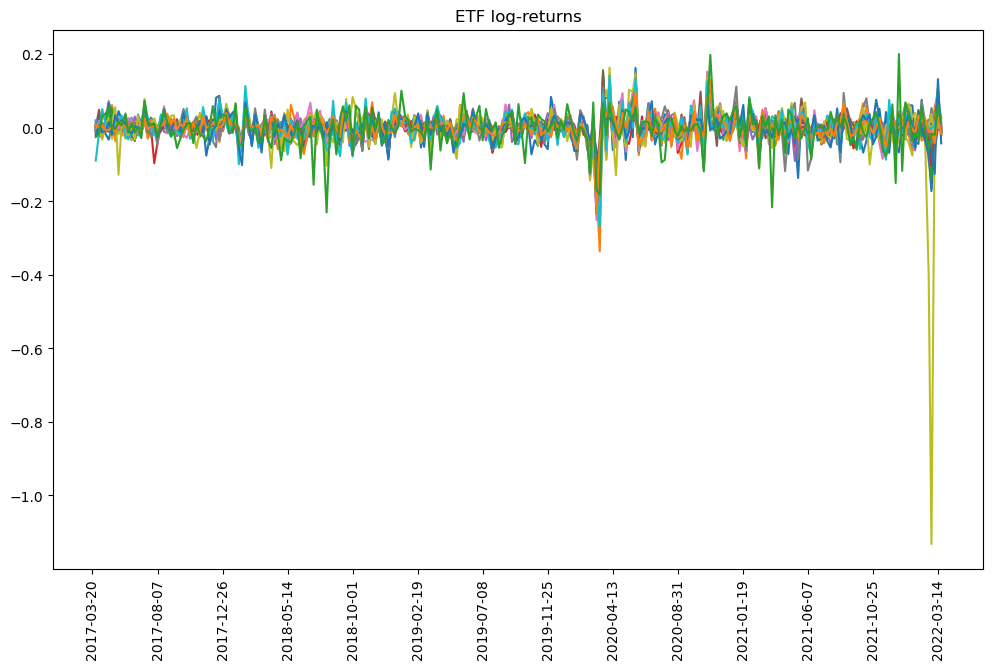

In [93]:
plt.figure(figsize=(12, 7))
plt.plot(dflogreturn)
plt.xlabel('')
plt.xticks(dates[np.arange(0, len(dates), 20)], rotation=90)
_ = plt.title('ETF log-returns')

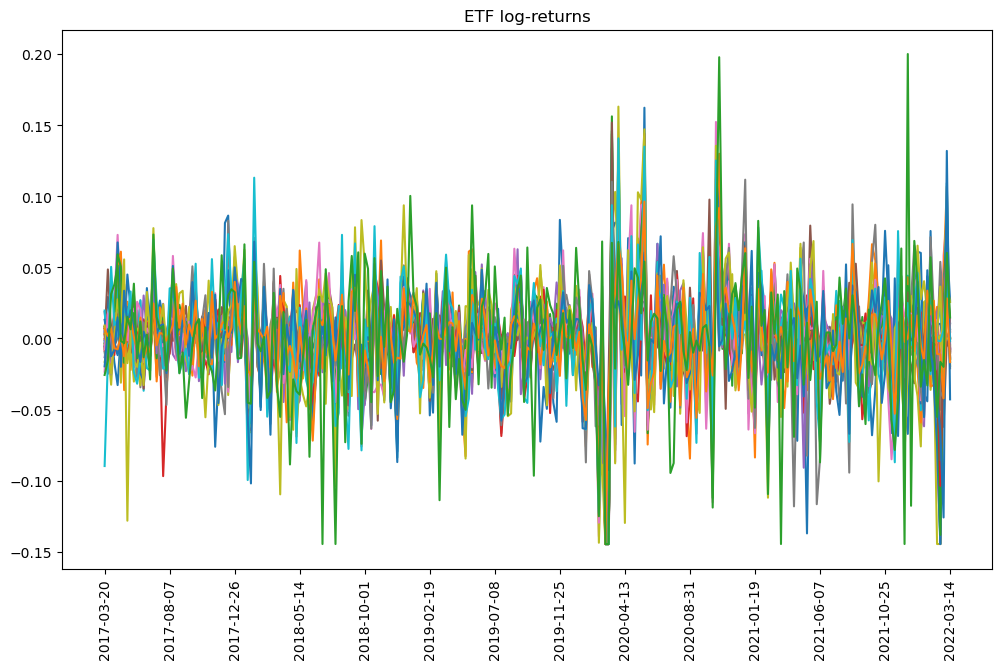

In [94]:
logreturns = np.array(np.log1p(df.pct_change()).iloc[1:])
clipped_logreturns = np.maximum(logreturns, -4*np.std(logreturns))
plt.figure(figsize=(12, 7))
plt.plot(clipped_logreturns)
plt.xlabel('')
plt.xticks(ticks=np.arange(0, len(dates), 20), labels=np.array(dates)[np.arange(0, len(dates), 20)].astype('M8[D]'), rotation=90)
_ = plt.title('ETF log-returns')


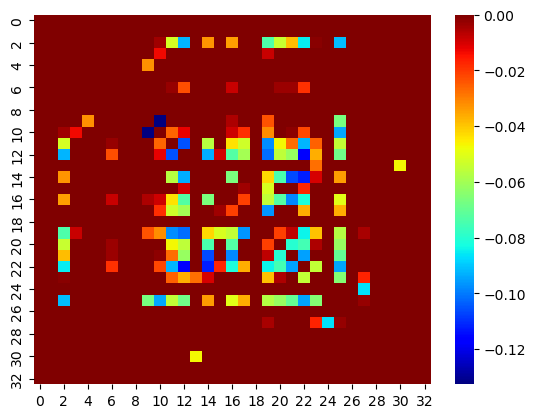

In [95]:
X = np.array(clipped_logreturns)
p = X.shape[1]
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
glasso = GraphicalLasso(alpha=.75).fit(X)
Omegahat = np.around(glasso.precision_, decimals=5)

for j in np.arange(p):
    Omegahat[j,j] = 0
sns.heatmap(Omegahat, cmap='jet')
plt.show()


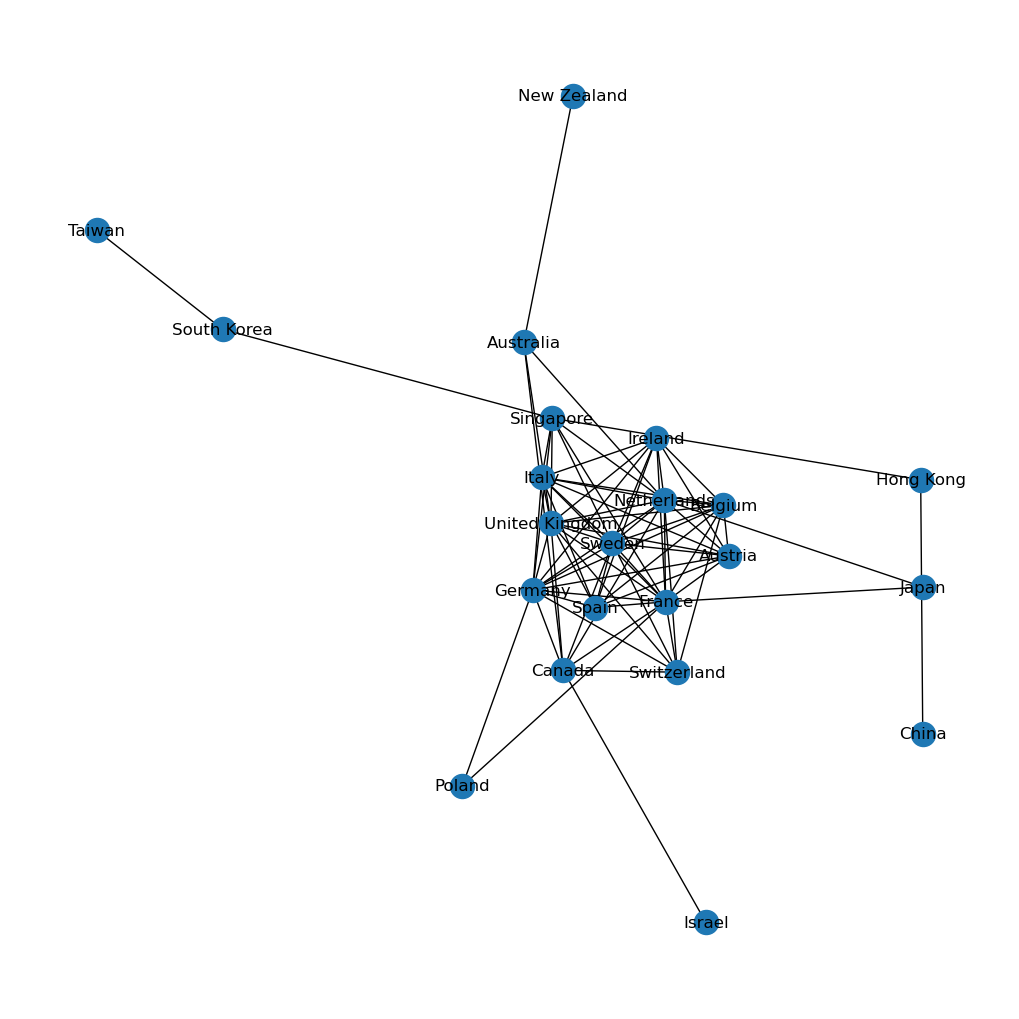

In [96]:
np.random.seed(42)

countries = [etfs[c] for c in dflogreturn.columns]
precdf = pd.DataFrame(Omegahat, columns=countries, index=countries)
links = precdf.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[(abs(links['value']) > 0.01) &  (links['var1'] != links['var2']) ]

#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()